# Assignment 1: Sampler Synthesis — Starter Code

This notebook provides baseline implementations of Random Walk Metropolis-Hastings and HMC using [BlackJAX](https://blackjax-devs.github.io/blackjax/). Use these as reference points for your novel sampler.

**Your task**: Design, implement, and analyze a novel MCMC sampler. Compare it to these baselines on the benchmark distributions.

In [56]:
import arviz as az
import blackjax
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["font.size"] = 12

---
## Benchmark Distribution: Rosenbrock (Banana)

The Rosenbrock distribution has a curved, narrow ridge that tests how well samplers handle strong correlations and curved geometry. This is challenging because:
- The high-probability region is thin and curved
- Random walk proposals often step off the ridge
- Samplers need to follow the curved geometry efficiently

In [57]:
def log_prob_rosenbrock(theta):
    """Rosenbrock (banana) distribution.

    log p(x, y) ∝ -(1-x)²/20 - (y - x²)²

    This creates a curved, banana-shaped distribution that tests
    how well samplers handle strong correlations and curved geometry.
    """
    x, y = theta[0], theta[1]
    return -0.05 * (1 - x) ** 2 - (y - x**2) ** 2

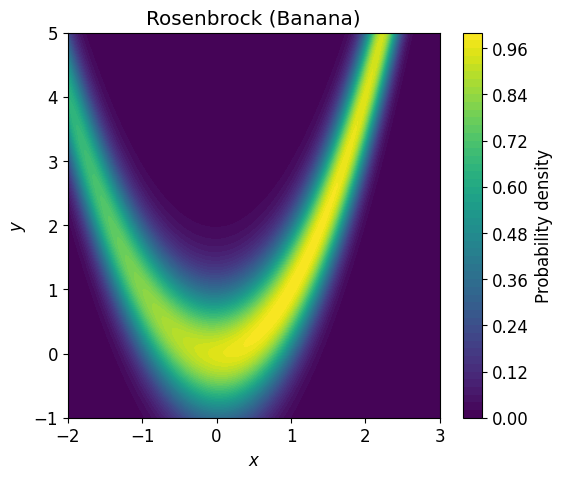

In [58]:
def plot_distribution(log_prob_fn, title, xlim=(-4, 4), ylim=(-4, 4)):
    """Visualize a 2D log probability distribution."""
    x = jnp.linspace(*xlim, 200)
    y = jnp.linspace(*ylim, 200)
    X, Y = jnp.meshgrid(x, y)
    positions = jnp.stack([X.ravel(), Y.ravel()], axis=-1)

    log_probs = jax.vmap(log_prob_fn)(positions).reshape(X.shape)

    plt.figure(figsize=(6, 5))
    plt.contourf(X, Y, jnp.exp(log_probs), levels=50, cmap="viridis")
    plt.colorbar(label="Probability density")
    plt.xlabel(r"$x$")
    plt.ylabel(r"$y$")
    plt.title(title)
    plt.show()


plot_distribution(log_prob_rosenbrock, "Rosenbrock (Banana)", xlim=(-2, 3), ylim=(-1, 5))

---
## Baseline 1: Random Walk Metropolis-Hastings

The simplest MCMC method. Proposes isotropic Gaussian steps — no gradient information.

**Tuning tip:** Target ~23-50% acceptance rate. Higher isn't better — it means steps are too small.

In [59]:
def run_rwmh(key, log_prob_fn, initial_position, sigma, n_samples):
    """Run Random Walk Metropolis-Hastings using BlackJAX.

    Args:
        key: JAX random key
        log_prob_fn: Log probability function
        initial_position: Starting point, shape (D,)
        sigma: Proposal standard deviation (scalar or array)
        n_samples: Number of samples to draw

    Returns:
        samples: Array of shape (n_samples, D)
        acceptance_rate: Fraction of accepted proposals
    """
    # Initialize the sampler with a normal proposal distribution
    rmh = blackjax.rmh(log_prob_fn, blackjax.mcmc.random_walk.normal(sigma))
    initial_state = rmh.init(initial_position)

    # Build the sampling loop
    @jax.jit
    def one_step(state, key):
        state, info = rmh.step(key, state)
        return state, (state.position, info.is_accepted)

    # Run the chain
    keys = jr.split(key, n_samples)
    _, (samples, accepted) = jax.lax.scan(one_step, initial_state, keys)

    return samples, accepted.mean()

---
## Baseline 2: Hamiltonian Monte Carlo (HMC)

Uses gradient information to make informed proposals. Typically much more efficient than random walk.

**Tuning tip:** Target ~65-90% acceptance rate. Tune step_size first, then n_leapfrog.

In [60]:
def run_hmc(key, log_prob_fn, initial_position, step_size, n_leapfrog, n_samples):
    """Run HMC using BlackJAX.

    Args:
        key: JAX random key
        log_prob_fn: Log probability function
        initial_position: Starting point, shape (D,)
        step_size: Leapfrog step size (epsilon)
        n_leapfrog: Number of leapfrog steps per iteration
        n_samples: Number of samples to draw

    Returns:
        samples: Array of shape (n_samples, D)
        acceptance_rate: Fraction of accepted proposals
    """
    # Initialize the sampler (identity mass matrix)
    inverse_mass_matrix = jnp.ones(initial_position.shape[0])
    hmc = blackjax.hmc(
        log_prob_fn,
        step_size=step_size,
        inverse_mass_matrix=inverse_mass_matrix,
        num_integration_steps=n_leapfrog,
    )
    initial_state = hmc.init(initial_position)

    # Build the sampling loop
    @jax.jit
    def one_step(state, key):
        state, info = hmc.step(key, state)
        return state, (state.position, info.acceptance_rate)

    # Run the chain
    keys = jr.split(key, n_samples)
    _, (samples, accepted) = jax.lax.scan(one_step, initial_state, keys)

    return samples, accepted.mean()

---
## Run Baselines on Rosenbrock

In [61]:
key = jr.PRNGKey(42)
key1, key2 = jr.split(key)

initial_pos = jnp.array([0.0, 0.0])
n_samples = 50_000

# Random Walk MH
rwmh_samples, rwmh_acc = run_rwmh(key1, log_prob_rosenbrock, initial_pos, sigma=1.0, n_samples=n_samples)
print(f"RWMH acceptance rate: {rwmh_acc:.2%}")

# HMC
hmc_samples, hmc_acc = run_hmc(
    key2, log_prob_rosenbrock, initial_pos, step_size=0.2, n_leapfrog=10, n_samples=n_samples
)
print(f"HMC acceptance rate: {hmc_acc:.2%}")

RWMH acceptance rate: 50.02%
HMC acceptance rate: 78.24%


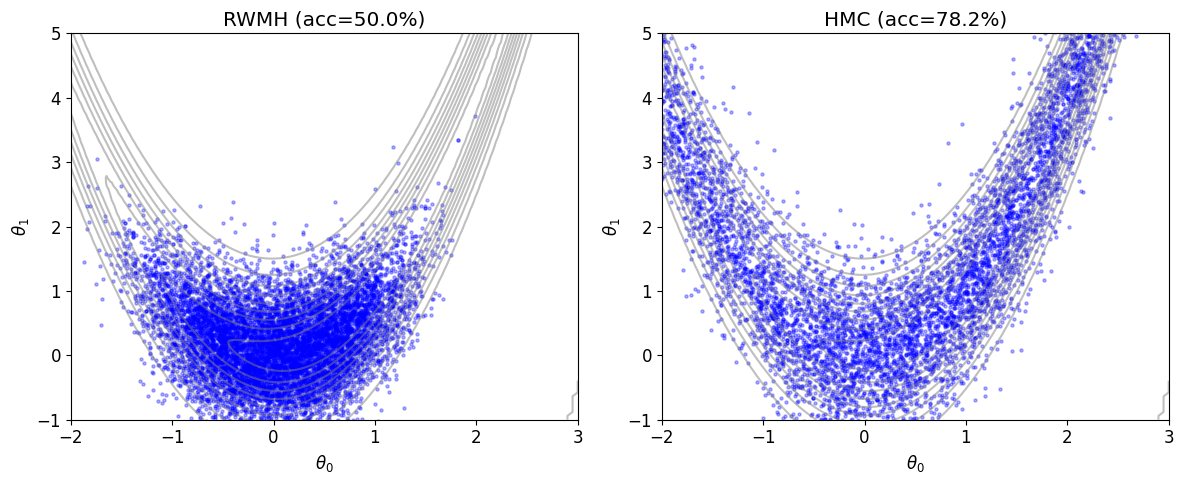

In [62]:
def plot_samples_comparison(samples1, samples2, label1, label2, log_prob_fn, xlim, ylim):
    """Plot samples from two methods side by side."""
    # Compute contours
    x = jnp.linspace(*xlim, 100)
    y = jnp.linspace(*ylim, 100)
    X, Y = jnp.meshgrid(x, y)
    positions = jnp.stack([X.ravel(), Y.ravel()], axis=-1)
    log_probs = jax.vmap(log_prob_fn)(positions).reshape(X.shape)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    for ax, samples, label in zip(axes, [samples1, samples2], [label1, label2]):
        ax.contour(X, Y, jnp.exp(log_probs), levels=10, colors="gray", alpha=0.5)
        ax.scatter(samples[::5, 0], samples[::5, 1], alpha=0.3, s=5, c="blue")
        ax.set_xlabel(r"$\theta_0$")
        ax.set_ylabel(r"$\theta_1$")
        ax.set_title(label)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

    plt.tight_layout()
    plt.show()


plot_samples_comparison(
    rwmh_samples,
    hmc_samples,
    f"RWMH (acc={rwmh_acc:.1%})",
    f"HMC (acc={hmc_acc:.1%})",
    log_prob_rosenbrock,
    xlim=(-2, 3),
    ylim=(-1, 5),
)

---
## Diagnostics with ArviZ

[ArviZ](https://python.arviz.org/) provides standard MCMC diagnostics. Key metrics:
- **Acceptance rate**: Too low = proposals too aggressive; too high = proposals too timid
- **Effective Sample Size (ESS)**: How many independent samples you effectively have
- **Trace plots**: Visual check for mixing and stationarity
- **Autocorrelation**: How correlated successive samples are

In [63]:
def samples_to_inference_data(samples, var_names=None):
    """Convert samples array to ArviZ InferenceData.

    Args:
        samples: Array of shape (n_samples, n_dims)
        var_names: Optional list of variable names

    Returns:
        ArviZ InferenceData object
    """
    if var_names is None:
        var_names = [f"theta_{i}" for i in range(samples.shape[1])]

    # ArviZ expects dict of {var_name: array} with shape (n_chains, n_samples)
    data_dict = {name: samples[None, :, i] for i, name in enumerate(var_names)}
    return az.convert_to_inference_data(data_dict)


def summarize_sampler(samples, name, var_names=None):
    """Print summary statistics for samples using ArviZ."""
    idata = samples_to_inference_data(samples, var_names)
    print(f"\n=== {name} ===")
    display(az.summary(idata, kind="stats"))

In [64]:
# Rosenbrock diagnostics
var_names = ["x", "y"]

rwmh_idata = samples_to_inference_data(rwmh_samples, var_names)
hmc_idata = samples_to_inference_data(hmc_samples, var_names)

# Summary statistics (mean, sd, ESS)
summarize_sampler(rwmh_samples, "RWMH — Rosenbrock", var_names)
summarize_sampler(hmc_samples, "HMC — Rosenbrock", var_names)


=== RWMH — Rosenbrock ===


,mean,sd,hdi_3%,hdi_97%
x,0.048,0.637,-1.105,1.206
y,0.266,0.659,-0.982,1.497



=== HMC — Rosenbrock ===


,mean,sd,hdi_3%,hdi_97%
x,0.622,2.040,-2.754,4.018
y,4.504,4.594,-0.507,15.117


RWMH Trace Plots:


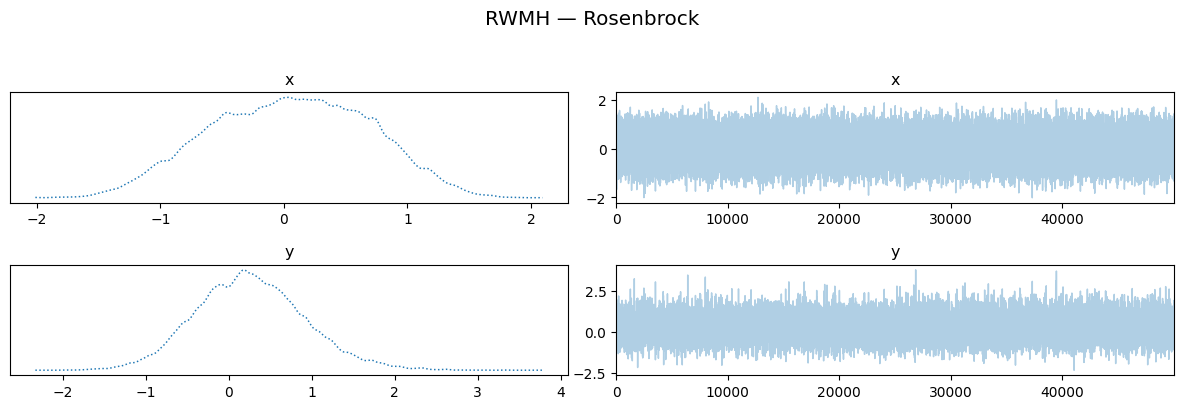


HMC Trace Plots:


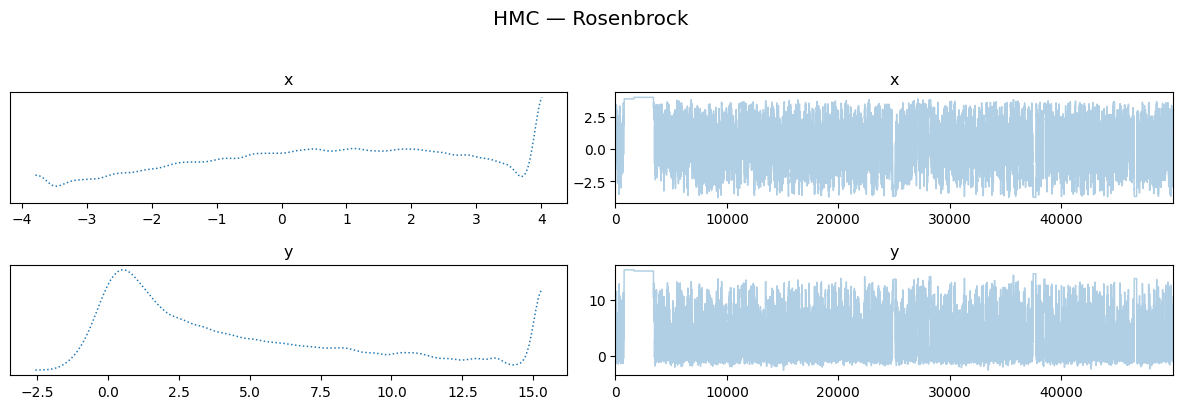

In [65]:
# Trace plots — Rosenbrock
print("RWMH Trace Plots:")
az.plot_trace(rwmh_idata, combined=True, figsize=(12, 4))
plt.suptitle("RWMH — Rosenbrock", y=1.02)
plt.tight_layout()
plt.show()

print("\nHMC Trace Plots:")
az.plot_trace(hmc_idata, combined=True, figsize=(12, 4))
plt.suptitle("HMC — Rosenbrock", y=1.02)
plt.tight_layout()
plt.show()

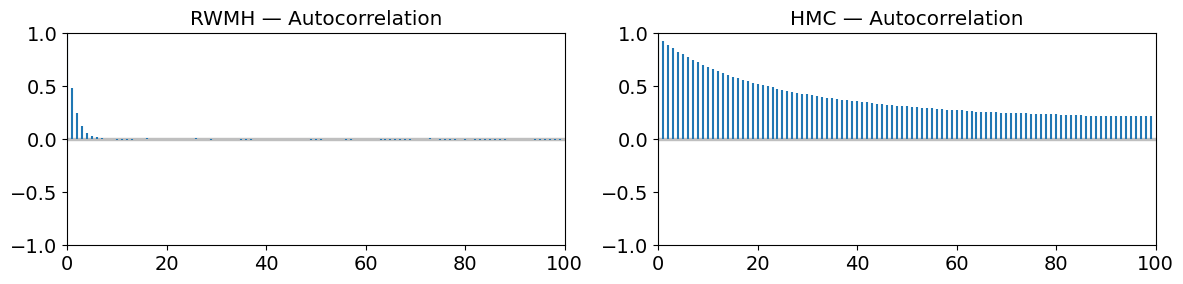

In [66]:
# Autocorrelation — Rosenbrock
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
az.plot_autocorr(rwmh_idata, ax=axes[0], combined=True)
axes[0].set_title("RWMH — Autocorrelation")
az.plot_autocorr(hmc_idata, ax=axes[1], combined=True)
axes[1].set_title("HMC — Autocorrelation")
plt.tight_layout()
plt.show()

---
## Discussion: Why Does RWMH Struggle Here?

Look carefully at the results above. You might notice something surprising: RWMH has *lower* autocorrelation than HMC, yet HMC explores the distribution much better. What's going on?

**The issue is local vs. global mixing.** RWMH with isotropic proposals faces a dilemma on curved distributions like the Rosenbrock:
- If the proposal scale is small enough to stay on the narrow ridge, it can't move far along the banana
- If the proposal scale is large enough to explore, most proposals step off the ridge and get rejected

So RWMH ends up jittering locally — samples decorrelate quickly *within* its local neighborhood, but it never traverses the full banana. Low autocorrelation doesn't mean good exploration!

**HMC uses gradients to follow the curve.** It makes long, coherent moves along the ridge without stepping off. The high autocorrelation is just because consecutive samples are along the same trajectory — but they're actually covering the full posterior.

This is exactly the kind of geometry where HMC shines, and one of the main motivations for gradient-based samplers.

---
## Benchmark Distribution 2: Neal's Funnel

Neal's Funnel is a hierarchical distribution that varies dramatically in scale across the space. The narrow "neck" of the funnel is notoriously difficult for fixed step-size samplers.

$$v \sim \mathcal{N}(0, 9), \quad x \sim \mathcal{N}(0, e^v)$$

This means:
- When $v$ is large and positive, $x$ can vary widely
- When $v$ is large and negative, $x$ is tightly constrained near 0
- A single step size can't work well everywhere

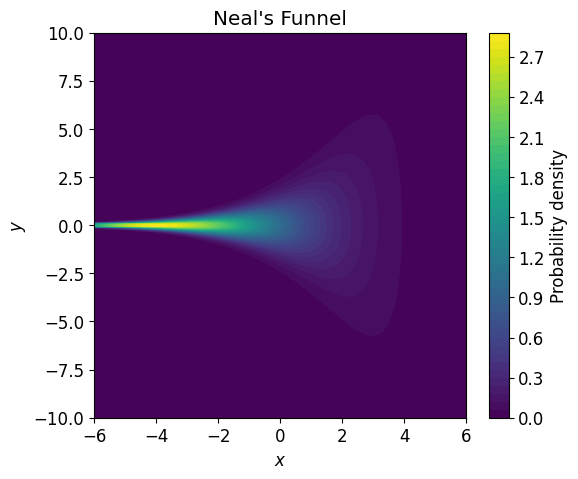

In [67]:
def log_prob_funnel(theta):
    """Neal's Funnel distribution.

    v ~ N(0, 9)
    x ~ N(0, exp(v))

    This creates a funnel shape where the scale of x depends on v.
    The narrow neck (small v) is very hard to sample.
    """
    v, x = theta[0], theta[1]
    log_p_v = -0.5 * v**2 / 9  # v ~ N(0, 9)
    log_p_x_given_v = -0.5 * x**2 * jnp.exp(-v) - 0.5 * v  # x ~ N(0, exp(v))
    return log_p_v + log_p_x_given_v


plot_distribution(log_prob_funnel, "Neal's Funnel", xlim=(-6, 6), ylim=(-10, 10))

In [68]:
# TODO: Run the RWMH and HMC baselines on Neal's Funnel
# Use the same workflow as Rosenbrock above — you'll need to tune hyperparameters!
key = jr.PRNGKey(123)
key1, key2 = jr.split(key)

n_samples = 50_000
initial_pos_funnel = jnp.array([0.0, 0.0])

# RWMH on Funnel
f_rwmh_samples, f_rwmh_acc = run_rwmh(
    key1, log_prob_funnel, initial_pos_funnel, sigma=1.0, n_samples=n_samples
)
print(f"Funnel RWMH acceptance rate: {f_rwmh_acc:.2%}")

# HMC on Funnel
f_hmc_samples, f_hmc_acc = run_hmc(
    key2, log_prob_funnel, initial_pos_funnel, step_size=0.2, n_leapfrog=10, n_samples=n_samples
)
print(f"Funnel HMC acceptance rate: {f_hmc_acc:.2%}")

Funnel RWMH acceptance rate: 65.31%
Funnel HMC acceptance rate: 90.99%


---
## Your Novel Sampler

Now it's your turn! Implement your own sampler below. Some ideas:

- **Adaptive proposals**: Adjust step size based on acceptance rate or local curvature
- **Hybrid methods**: Combine different move types (e.g., local + global moves)
- **Modified dynamics**: Change the Hamiltonian, use different integrators, add friction
- **Tempering**: Use temperature schedules to help exploration

A simple idea with thorough analysis beats a complex idea you don't understand!

In [69]:
import jax
import jax.numpy as jnp
import jax.random as jr

def _log_gaussian(x, mean, cov_inv, logdet_cov):
    """log N(x; mean, Σ) given Σ^{-1} and logdet(Σ)."""
    d = x.shape[0]
    dx = x - mean
    quad = dx @ (cov_inv @ dx)
    return -0.5 * (d * jnp.log(2.0 * jnp.pi) + logdet_cov + quad)

def _cov_inv_and_logdet_rank1(u_hat, sigma_perp, sigma_par):
    """
    Σ = σ_perp^2 I + (σ_par^2 - σ_perp^2) u u^T, where ||u||=1
    return Σ^{-1}, logdet(Σ)
    """
    a = sigma_perp**2
    b = sigma_par**2 - sigma_perp**2
    d = u_hat.shape[0]

    inv = (1.0 / a) * jnp.eye(d) - (b / (a * (a + b))) * jnp.outer(u_hat, u_hat)
    logdet = (d - 1) * jnp.log(a) + jnp.log(a + b)
    return inv, logdet

def _sample_rank1_gaussian(key, u_hat, sigma_perp, sigma_par):
    """
    Sample η ~ N(0, Σ) where Σ = σ_perp^2 I + (σ_par^2 - σ_perp^2) u u^T, ||u||=1
    """
    z = jr.normal(key, shape=u_hat.shape)
    z_par = jnp.dot(u_hat, z)
    eta = sigma_perp * z + (sigma_par - sigma_perp) * u_hat * z_par
    return eta

def run_my_sampler(
    key,
    log_prob_fn,
    initial_position,
    n_samples,
    sigma_perp=0.6,
    sigma_par=0.12,
    drift=0.05,
    mix_prob=0.10,
    sigma_rw=0.3,
    eps=1e-8,
):
    """
    Tangent–Normal Metropolis (TNM) sampler.
    - Uses score direction (grad log p) as local normal.
    - Makes large moves in orthogonal subspace (sigma_perp) and small moves along score (sigma_par).
    - Optional drift along score (drift) and mixture with isotropic RWMH (mix_prob) for robustness.
    """
    D = initial_position.shape[0]
    grad_logp = jax.grad(log_prob_fn)

    def one_step(x, key):
        k1, k2, k3 = jr.split(key, 3)

        logp_x = log_prob_fn(x)
        g = grad_logp(x)
        g_hat = g / (jnp.linalg.norm(g) + eps)

        do_rw = jr.uniform(k1) < mix_prob

        def tnm_propose(_):
            cov_inv, logdet = _cov_inv_and_logdet_rank1(g_hat, sigma_perp, sigma_par)
            mean_fwd = x + drift * g_hat
            eta = _sample_rank1_gaussian(k2, g_hat, sigma_perp, sigma_par)
            x_prop = mean_fwd + eta

            logp_prop = log_prob_fn(x_prop)

            # backward proposal q(x | x_prop)
            g2 = grad_logp(x_prop)
            g2_hat = g2 / (jnp.linalg.norm(g2) + eps)
            cov_inv2, logdet2 = _cov_inv_and_logdet_rank1(g2_hat, sigma_perp, sigma_par)
            mean_bwd = x_prop + drift * g2_hat

            logq_fwd = _log_gaussian(x_prop, mean_fwd, cov_inv, logdet)
            logq_bwd = _log_gaussian(x, mean_bwd, cov_inv2, logdet2)

            log_alpha = (logp_prop - logp_x) + (logq_bwd - logq_fwd)
            accept = jnp.log(jr.uniform(k3)) < log_alpha
            x_new = jnp.where(accept, x_prop, x)
            return x_new, accept

        def rw_propose(_):
            x_prop = x + sigma_rw * jr.normal(k2, shape=(D,))
            logp_prop = log_prob_fn(x_prop)
            log_alpha = logp_prop - logp_x
            accept = jnp.log(jr.uniform(k3)) < log_alpha
            x_new = jnp.where(accept, x_prop, x)
            return x_new, accept

        x_new, accept = jax.lax.cond(do_rw, rw_propose, tnm_propose, operand=None)
        return x_new, (x_new, accept)

    keys = jr.split(key, n_samples)
    _, (samples, accepted) = jax.lax.scan(one_step, initial_position, keys)
    return samples, accepted.mean()

In [99]:
# TODO: Test your sampler on both benchmarks (Rosenbrock and Neal's Funnel)
# my_samples, my_acc = run_my_sampler(key, log_prob_rosenbrock, initial_pos, n_samples=50_000, ...)
initial_pos_funnel = jnp.array([0.0, 0.0])
key = jr.PRNGKey(1)
key_rb, key_fn = jr.split(key)

# Rosenbrock
my_samples_rb, my_acc_rb = run_my_sampler(
    key_rb,
    log_prob_rosenbrock,
    initial_pos,
    n_samples=50_000,
    sigma_perp=0.35,
    sigma_par=0.08,
    drift=0.00,
    mix_prob=0.1,
    sigma_rw=0.15,
)
print(f"My Sampler (TNM) — Rosenbrock acceptance: {my_acc_rb:.2%}")

# Neal's Funnel
my_samples_fn, my_acc_fn = run_my_sampler(
    key_fn,
    log_prob_funnel,
    initial_pos_funnel,
    n_samples=50_000,
    sigma_perp=0.45,
    sigma_par=0.05,
    drift=0.00,
    mix_prob=0.45,
    sigma_rw=0.2,
)
print(f"My Sampler (TNM) — Funnel acceptance: {my_acc_fn:.2%}")

My Sampler (TNM) — Rosenbrock acceptance: 73.80%
My Sampler (TNM) — Funnel acceptance: 71.86%


In [100]:
# --- Funnel baselines (save samples for plotting) ---
initial_pos_funnel = jnp.array([0.0, 0.0])

key = jr.PRNGKey(123)
key1, key2 = jr.split(key)

rwmh_samples_funnel, rwmh_acc_funnel = run_rwmh(
    key1,
    log_prob_funnel,
    initial_pos_funnel,
    sigma=0.5,          # 你之前 tune 出来的参数就用你自己的
    n_samples=50_000
)
print(f"Funnel RWMH acceptance rate: {rwmh_acc_funnel:.2%}")

hmc_samples_funnel, hmc_acc_funnel = run_hmc(
    key2,
    log_prob_funnel,
    initial_pos_funnel,
    step_size=0.1,      # 用你之前 tune 的 step_size / leapfrog
    n_leapfrog=10,
    n_samples=50_000
)
print(f"Funnel HMC acceptance rate: {hmc_acc_funnel:.2%}")

Funnel RWMH acceptance rate: 84.53%
Funnel HMC acceptance rate: 97.85%


In [101]:

# TODO: Test your sampler on Rosenbrock
# my_samples, my_acc = run_my_sampler(key, log_prob_rosenbrock, initial_pos, n_samples=50_000, ...)
key = jr.PRNGKey(0)

my_samples_rb, my_acc_rb = run_my_sampler(
    key,
    log_prob_rosenbrock,
    initial_pos,
    n_samples=50_000,
    sigma_perp=0.6,
    sigma_par=0.12,
    drift=0.05,
    mix_prob=0.10,
    sigma_rw=0.3,
)

print(f"My Sampler (TNM) — Rosenbrock acceptance: {my_acc_rb:.2%}")

My Sampler (TNM) — Rosenbrock acceptance: 69.35%


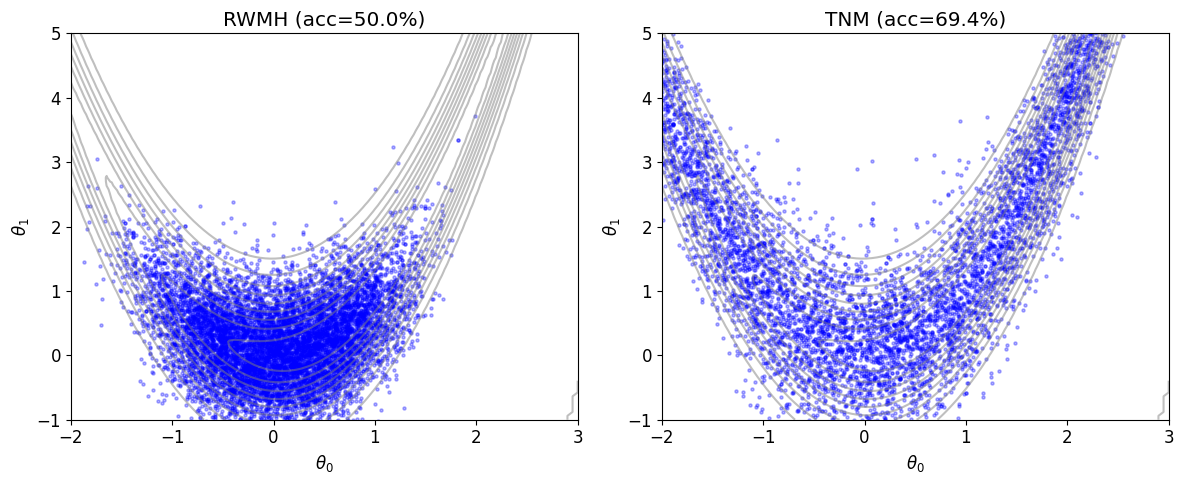

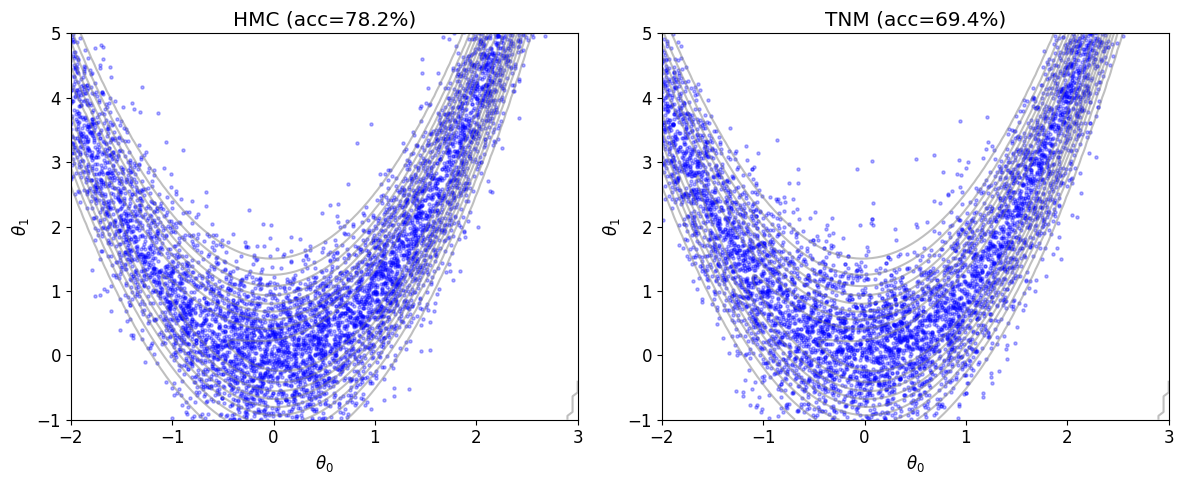


=== Rosenbrock — ESS / stats ===

RWMH — Rosenbrock


,mean,sd,hdi_3%,hdi_97%
x,0.048,0.637,-1.105,1.206
y,0.266,0.659,-0.982,1.497



HMC — Rosenbrock


,mean,sd,hdi_3%,hdi_97%
x,0.622,2.040,-2.754,4.018
y,4.504,4.594,-0.507,15.117



TNM — Rosenbrock


,mean,sd,hdi_3%,hdi_97%
x,0.162,2.329,-4.490,4.298
y,5.445,6.855,-1.484,19.710



Rosenbrock Trace Plots:


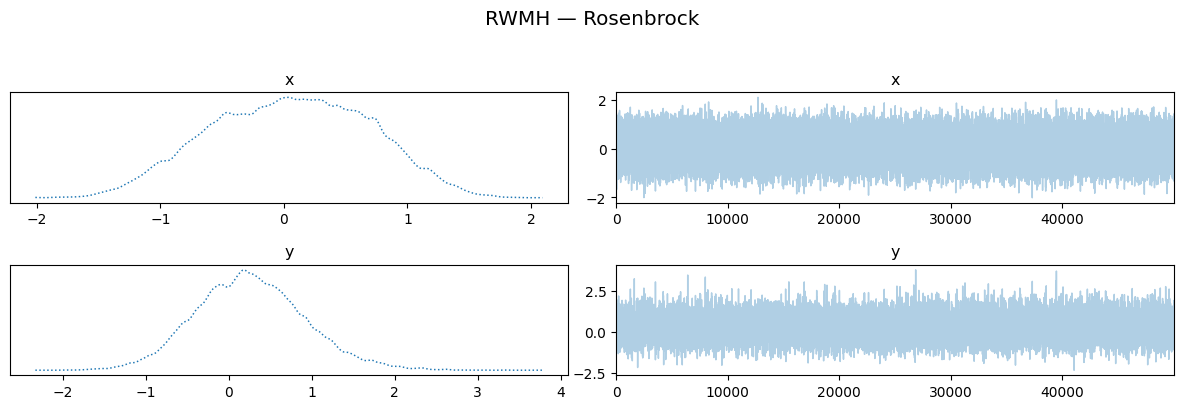

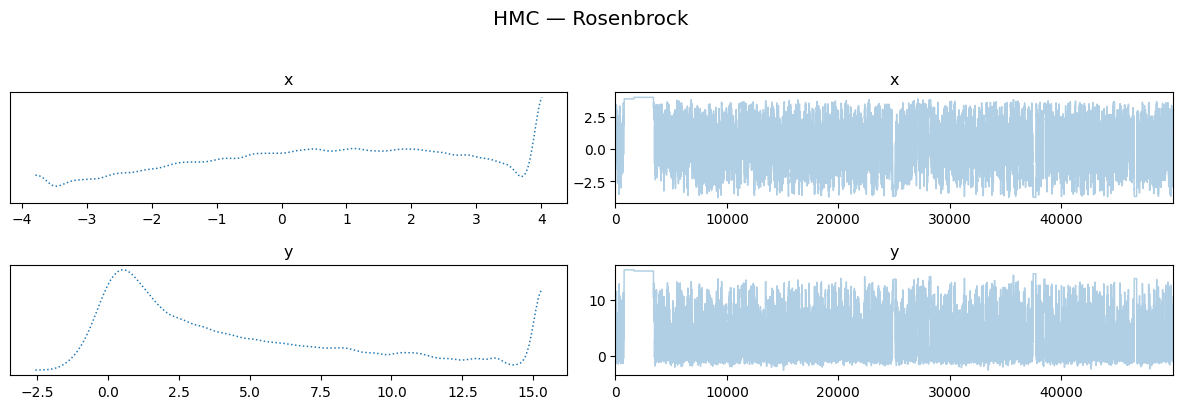

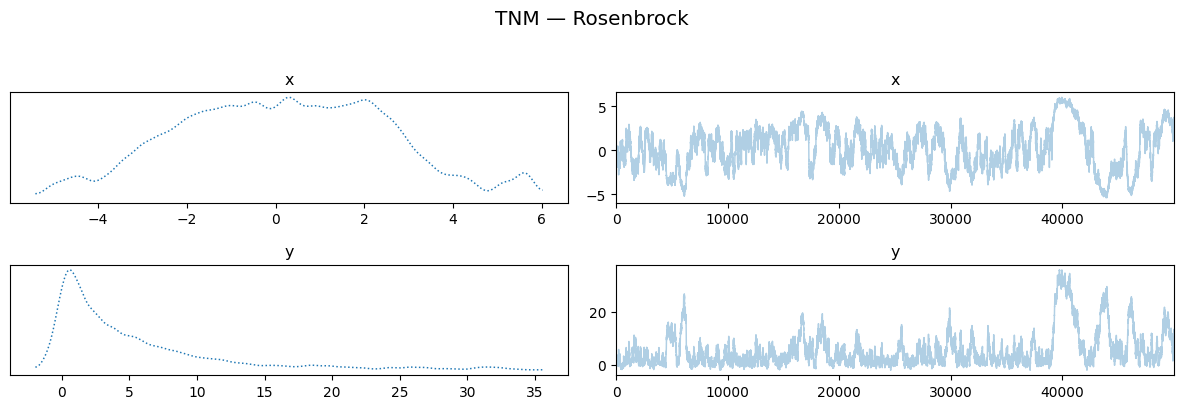

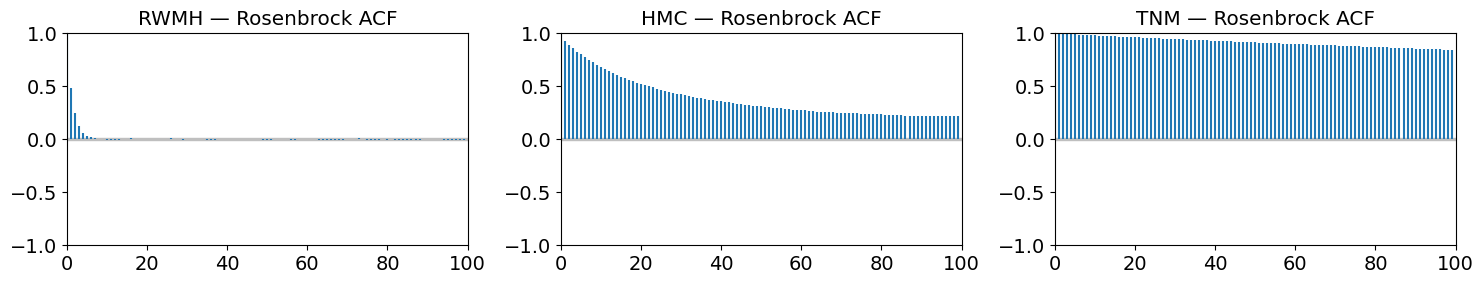

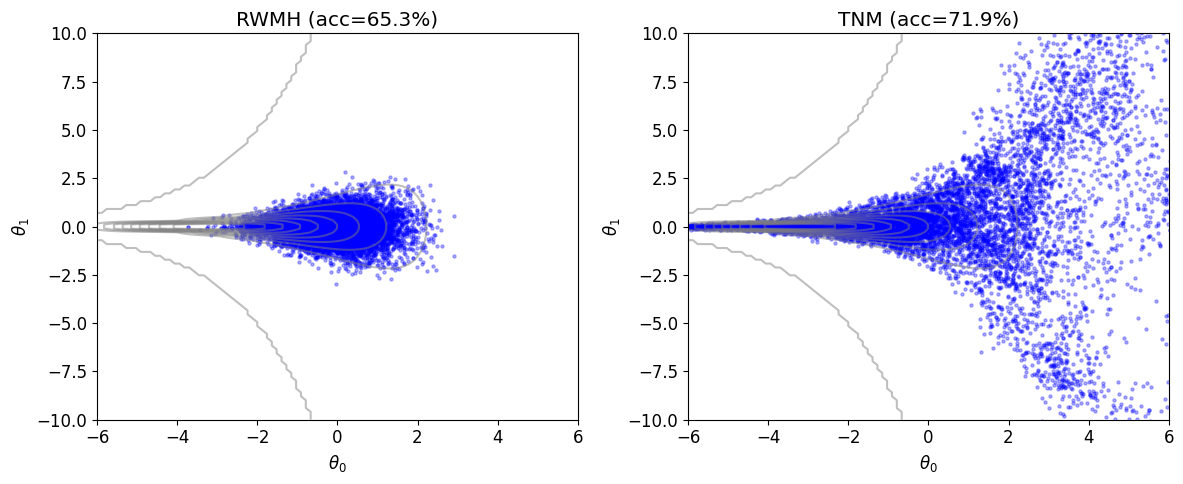

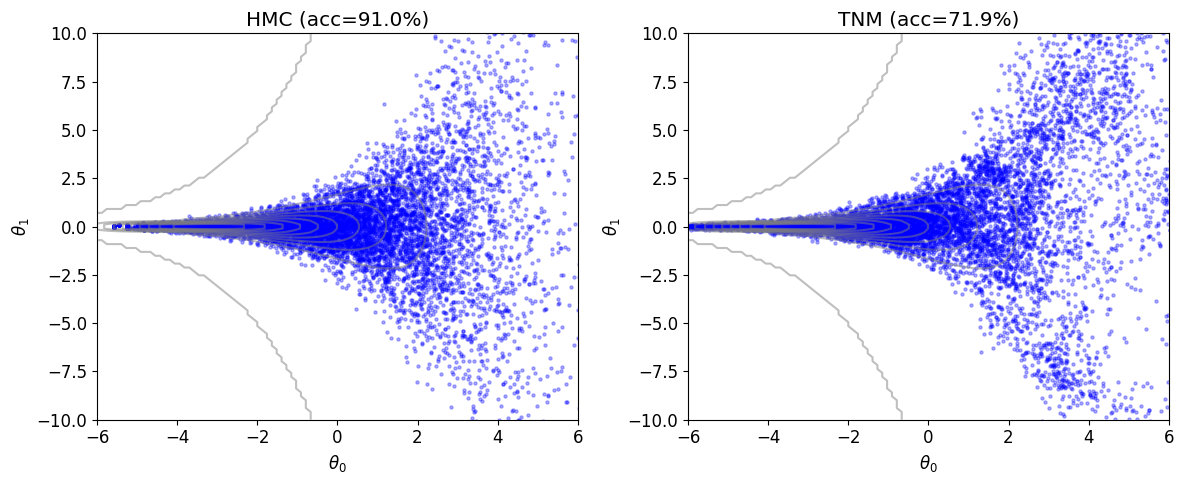


=== Funnel — ESS / stats ===

RWMH — Funnel


,mean,sd,hdi_3%,hdi_97%
v,-0.210,0.907,-1.929,1.478
x,-0.001,0.675,-1.267,1.307



HMC — Funnel


,mean,sd,hdi_3%,hdi_97%
v,0.374,3.117,-5.578,5.674
x,2.875,15.115,-11.166,18.900



TNM — Funnel


,mean,sd,hdi_3%,hdi_97%
v,-0.040,3.079,-5.798,5.546
x,0.672,3.675,-5.619,11.776



Funnel Trace Plots:


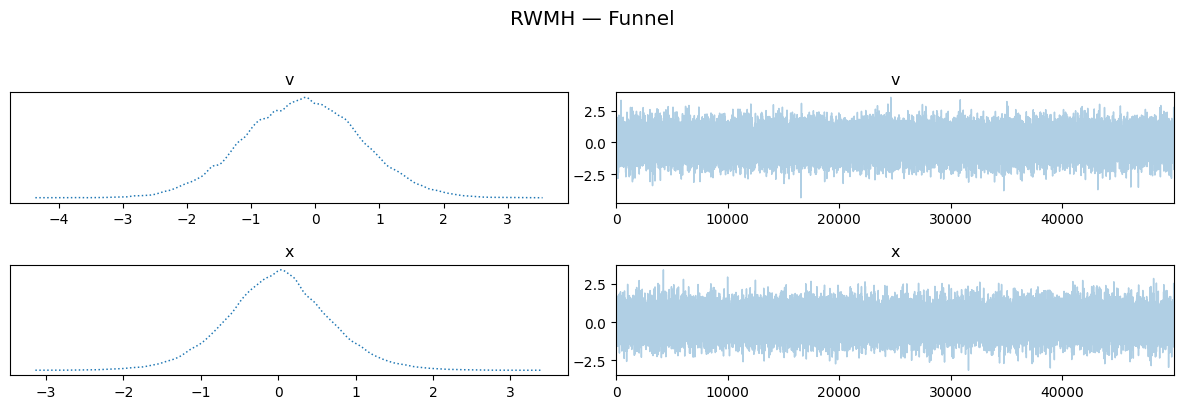

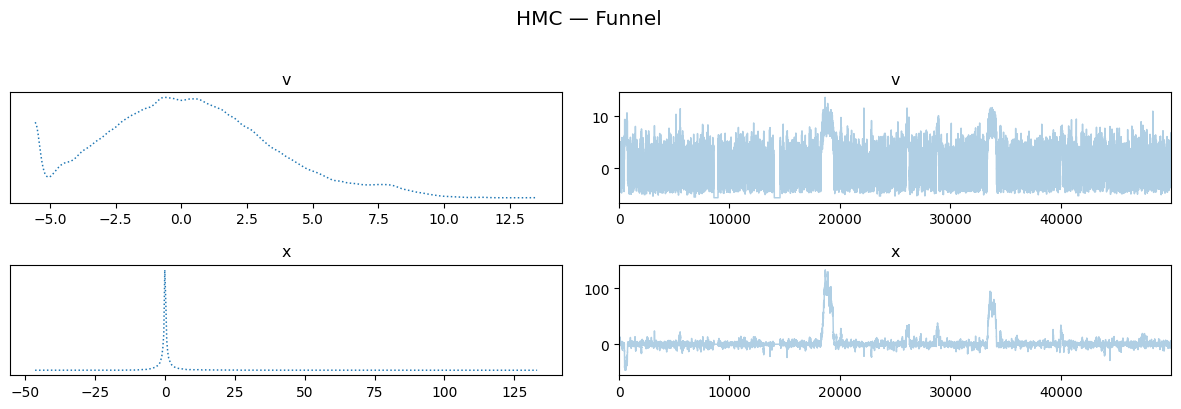

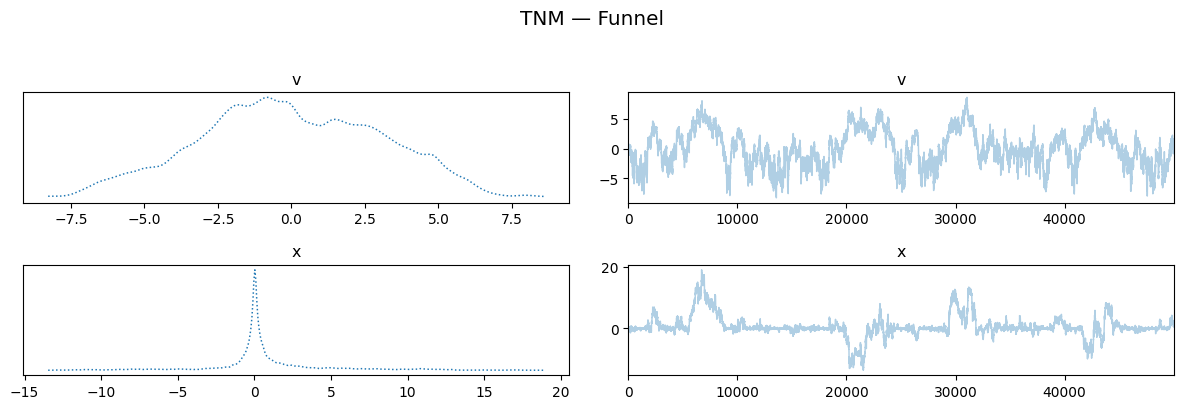

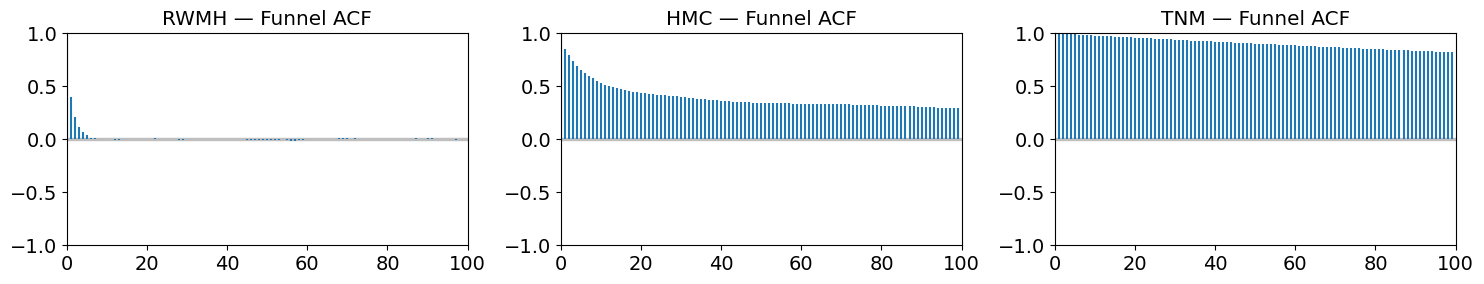

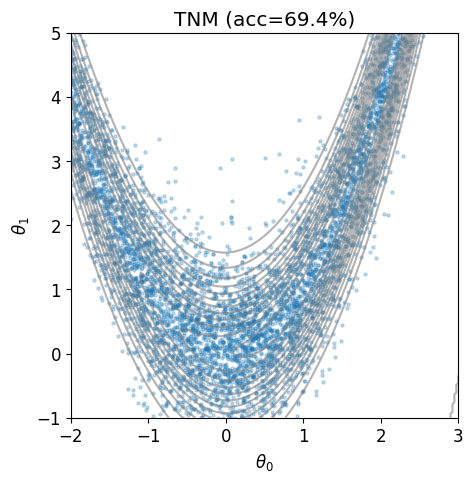

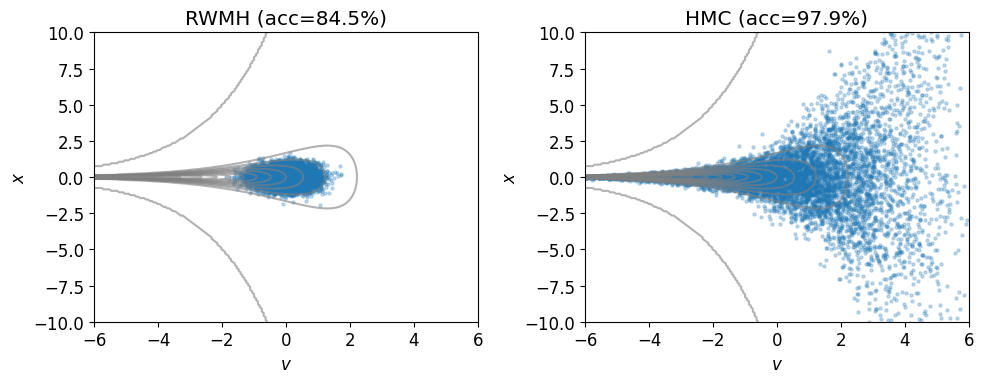

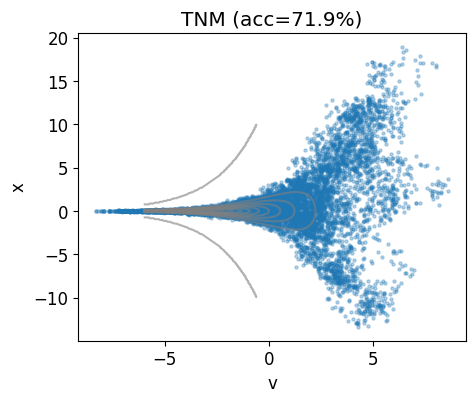

In [107]:
# TODO: Compare to baselines
# - Visualize samples (scatter plot with contours)
# - Compute ESS using samples_to_inference_data() and az.summary()
# - Plot traces and autocorrelation
# - Discuss: where does your method work well? Where does it struggle?
import arviz as az
import matplotlib.pyplot as plt

# -----------------------------
# 1) Rosenbrock: visuals
# -----------------------------
plot_samples_comparison(
    rwmh_samples,
    my_samples_rb,
    f"RWMH (acc={rwmh_acc:.1%})",
    f"TNM (acc={my_acc_rb:.1%})",
    log_prob_rosenbrock,
    xlim=(-2, 3),
    ylim=(-1, 5),
)

plot_samples_comparison(
    hmc_samples,
    my_samples_rb,
    f"HMC (acc={hmc_acc:.1%})",
    f"TNM (acc={my_acc_rb:.1%})",
    log_prob_rosenbrock,
    xlim=(-2, 3),
    ylim=(-1, 5),
)

# -----------------------------
# 2) Rosenbrock: ESS + traces + autocorr
# -----------------------------
var_names_rb = ["x", "y"]
rb_rwmh_idata = samples_to_inference_data(rwmh_samples, var_names_rb)
rb_hmc_idata  = samples_to_inference_data(hmc_samples,  var_names_rb)
rb_tnm_idata  = samples_to_inference_data(my_samples_rb, var_names_rb)

print("\n=== Rosenbrock — ESS / stats ===")
print("\nRWMH — Rosenbrock")
display(az.summary(rb_rwmh_idata, kind="stats"))
print("\nHMC — Rosenbrock")
display(az.summary(rb_hmc_idata, kind="stats"))
print("\nTNM — Rosenbrock")
display(az.summary(rb_tnm_idata, kind="stats"))

print("\nRosenbrock Trace Plots:")
az.plot_trace(rb_rwmh_idata, combined=True, figsize=(12, 4))
plt.suptitle("RWMH — Rosenbrock", y=1.02); plt.tight_layout(); plt.show()

az.plot_trace(rb_hmc_idata, combined=True, figsize=(12, 4))
plt.suptitle("HMC — Rosenbrock", y=1.02); plt.tight_layout(); plt.show()

az.plot_trace(rb_tnm_idata, combined=True, figsize=(12, 4))
plt.suptitle("TNM — Rosenbrock", y=1.02); plt.tight_layout(); plt.show()

fig, axes = plt.subplots(1, 3, figsize=(15, 3))
az.plot_autocorr(rb_rwmh_idata, ax=axes[0], combined=True); axes[0].set_title("RWMH — Rosenbrock ACF")
az.plot_autocorr(rb_hmc_idata,  ax=axes[1], combined=True); axes[1].set_title("HMC — Rosenbrock ACF")
az.plot_autocorr(rb_tnm_idata,  ax=axes[2], combined=True); axes[2].set_title("TNM — Rosenbrock ACF")
plt.tight_layout(); plt.show()

# -----------------------------
# 3) Funnel: visuals
# -----------------------------
plot_samples_comparison(
    f_rwmh_samples,
    my_samples_fn,
    f"RWMH (acc={f_rwmh_acc:.1%})",
    f"TNM (acc={my_acc_fn:.1%})",
    log_prob_funnel,
    xlim=(-6, 6),
    ylim=(-10, 10),
)

plot_samples_comparison(
    f_hmc_samples,
    my_samples_fn,
    f"HMC (acc={f_hmc_acc:.1%})",
    f"TNM (acc={my_acc_fn:.1%})",
    log_prob_funnel,
    xlim=(-6, 6),
    ylim=(-10, 10),
)

# -----------------------------
# 4) Funnel: ESS + traces + autocorr
# -----------------------------
var_names_fn = ["v", "x"]
fn_rwmh_idata = samples_to_inference_data(f_rwmh_samples, var_names_fn)
fn_hmc_idata  = samples_to_inference_data(f_hmc_samples,  var_names_fn)
fn_tnm_idata  = samples_to_inference_data(my_samples_fn,   var_names_fn)

print("\n=== Funnel — ESS / stats ===")
print("\nRWMH — Funnel")
display(az.summary(fn_rwmh_idata, kind="stats"))
print("\nHMC — Funnel")
display(az.summary(fn_hmc_idata, kind="stats"))
print("\nTNM — Funnel")
display(az.summary(fn_tnm_idata, kind="stats"))

print("\nFunnel Trace Plots:")
az.plot_trace(fn_rwmh_idata, combined=True, figsize=(12, 4))
plt.suptitle("RWMH — Funnel", y=1.02); plt.tight_layout(); plt.show()

az.plot_trace(fn_hmc_idata, combined=True, figsize=(12, 4))
plt.suptitle("HMC — Funnel", y=1.02); plt.tight_layout(); plt.show()

az.plot_trace(fn_tnm_idata, combined=True, figsize=(12, 4))
plt.suptitle("TNM — Funnel", y=1.02); plt.tight_layout(); plt.show()

fig, axes = plt.subplots(1, 3, figsize=(15, 3))
az.plot_autocorr(fn_rwmh_idata, ax=axes[0], combined=True); axes[0].set_title("RWMH — Funnel ACF")
az.plot_autocorr(fn_hmc_idata,  ax=axes[1], combined=True); axes[1].set_title("HMC — Funnel ACF")
az.plot_autocorr(fn_tnm_idata,  ax=axes[2], combined=True); axes[2].set_title("TNM — Funnel ACF")
plt.tight_layout(); plt.show()

# --- Rosenbrock TNM figure (single-panel) ---
xlim, ylim = (-2, 3), (-1, 5)

x = jnp.linspace(*xlim, 200)
y = jnp.linspace(*ylim, 200)
X, Y = jnp.meshgrid(x, y)
pos = jnp.stack([X.ravel(), Y.ravel()], axis=-1)
logp_grid = jax.vmap(log_prob_rosenbrock)(pos).reshape(X.shape)

plt.figure(figsize=(5, 5))
plt.contour(X, Y, jnp.exp(logp_grid), levels=12, colors="gray", alpha=0.6)
plt.scatter(my_samples_rb[::5, 0], my_samples_rb[::5, 1], s=5, alpha=0.25)
plt.title(f"TNM (acc={float(my_acc_rb)*100:.1f}%)")
plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\theta_1$")
plt.xlim(xlim); plt.ylim(ylim)

plt.show()


# --- Funnel Baselines (RWMH vs HMC) ---

xlim, ylim = (-6, 6), (-10, 10)

x = jnp.linspace(*xlim, 200)
y = jnp.linspace(*ylim, 200)
X, Y = jnp.meshgrid(x, y)
pos = jnp.stack([X.ravel(), Y.ravel()], axis=-1)
logp_grid = jax.vmap(log_prob_funnel)(pos).reshape(X.shape)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

for ax, samples, title in zip(
    axes,
    [rwmh_samples_funnel, hmc_samples_funnel],
    [f"RWMH (acc={rwmh_acc_funnel*100:.1f}%)",
     f"HMC (acc={hmc_acc_funnel*100:.1f}%)"]
):
    ax.contour(X, Y, jnp.exp(logp_grid), levels=12, colors="gray", alpha=0.6)
    ax.scatter(samples[::5, 0], samples[::5, 1], s=5, alpha=0.25)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title(title)
    ax.set_xlabel(r"$v$")
    ax.set_ylabel(r"$x$")

plt.tight_layout()
plt.show()

plt.figure(figsize=(5,4))
plt.contour(X, Y, jnp.exp(logp_grid), levels=12, colors="gray", alpha=0.6)
plt.scatter(my_samples_fn[::5,0], my_samples_fn[::5,1], s=5, alpha=0.3)
plt.xlabel("v")
plt.ylabel("x")
plt.title(f"TNM (acc={my_acc_fn*100:.1f}%)")
plt.show()

In [104]:
# TODO: Ablation study
# - What are the key hyperparameters of your method?
# - How sensitive is performance to each one?
# - What happens in limiting cases (e.g., turning off a component)?
import arviz as az
import pandas as pd
import jax.numpy as jnp
import jax.random as jr

def ess_from_idata(idata, var_names):
    """
    Compute ESS using az.ess (robust across ArviZ versions).
    Returns a dict {var_name: ess_value}.
    """
    ess_ds = az.ess(idata, var_names=var_names)  # xarray Dataset
    out = {}
    for v in var_names:
        # ess_ds[v] is an xarray DataArray; for scalar variable it's 0-d
        out[v] = float(ess_ds[v].values)
    return out

def run_and_score(key, logp, init_pos, n_samples, params, var_names, burn_frac=0.2):
    samples, acc = run_my_sampler(key, logp, init_pos, n_samples=n_samples, **params)

    # burn-in
    burn = int(burn_frac * samples.shape[0])
    samples_eff = samples[burn:]

    idata = samples_to_inference_data(samples_eff, var_names)
    ess_dict = ess_from_idata(idata, var_names)

    row = {"acc": float(acc)}
    for v in var_names:
        row[f"ess_{v}"] = ess_dict[v]
    return row

# Keep ablation cheap; increase later if you want
n_ablate = 20_000

# -----------------------------
# Rosenbrock ablation
# -----------------------------
key = jr.PRNGKey(10)

rb_base = dict(sigma_perp=0.6, sigma_par=0.12, drift=0.05, mix_prob=0.10, sigma_rw=0.3)
rb_vars = ["x", "y"]

rb_settings = [
    ("base", rb_base),
    ("no_drift", {**rb_base, "drift": 0.0}),
    ("no_mix",   {**rb_base, "mix_prob": 0.0}),
]

for s_par in [0.05, 0.10, 0.15, 0.20]:
    rb_settings.append((f"sigma_par={s_par}", {**rb_base, "sigma_par": s_par}))

for s_perp in [0.3, 0.6, 0.9]:
    rb_settings.append((f"sigma_perp={s_perp}", {**rb_base, "sigma_perp": s_perp}))

rb_rows = []
for name, params in rb_settings:
    key, subkey = jr.split(key)
    metrics = run_and_score(subkey, log_prob_rosenbrock, initial_pos, n_ablate, params, rb_vars)
    rb_rows.append({"benchmark": "rosenbrock", "setting": name, **params, **metrics})

# -----------------------------
# Funnel ablation
# -----------------------------
key = jr.PRNGKey(20)

if "initial_pos_funnel" not in globals():
    initial_pos_funnel = jnp.array([0.0, 0.0])

fn_base = dict(sigma_perp=0.9, sigma_par=0.05, drift=0.02, mix_prob=0.25, sigma_rw=0.6)
fn_vars = ["v", "x"]

fn_settings = [
    ("base", fn_base),
    ("no_drift", {**fn_base, "drift": 0.0}),
    ("no_mix",   {**fn_base, "mix_prob": 0.0}),
]

for s_par in [0.03, 0.05, 0.08, 0.12]:
    fn_settings.append((f"sigma_par={s_par}", {**fn_base, "sigma_par": s_par}))

for s_perp in [0.6, 0.9, 1.2]:
    fn_settings.append((f"sigma_perp={s_perp}", {**fn_base, "sigma_perp": s_perp}))

fn_rows = []
for name, params in fn_settings:
    key, subkey = jr.split(key)
    metrics = run_and_score(subkey, log_prob_funnel, initial_pos_funnel, n_ablate, params, fn_vars)
    fn_rows.append({"benchmark": "funnel", "setting": name, **params, **metrics})

# -----------------------------
# Display
# -----------------------------
df = pd.DataFrame(rb_rows + fn_rows)

show_cols = [
    "benchmark", "setting",
    "sigma_perp", "sigma_par", "drift", "mix_prob",
    "acc",
    "ess_x", "ess_y", "ess_v",
]
safe_cols = [c for c in show_cols if c in df.columns]
display(df[safe_cols].sort_values(["benchmark", "setting"]))



,benchmark,setting,sigma_perp,sigma_par,drift,mix_prob,acc,ess_x,ess_y,ess_v
10,funnel,base,0.9,0.05,0.02,0.25,0.49040,33.860273,NaN,14.095208
11,funnel,no_drift,0.9,0.05,0.00,0.25,0.48980,86.540066,NaN,28.624071
12,funnel,no_mix,0.9,0.05,0.02,0.00,0.46950,12.468626,NaN,8.589249
13,funnel,sigma_par=0.03,0.9,0.03,0.02,0.25,0.40375,40.231114,NaN,34.702006
14,funnel,sigma_par=0.05,0.9,0.05,0.02,0.25,0.49585,42.029133,NaN,46.438790
15,funnel,sigma_par=0.08,0.9,0.08,0.02,0.25,0.53775,120.477263,NaN,20.349762
16,funnel,sigma_par=0.12,0.9,0.12,0.02,0.25,0.57600,61.064921,NaN,10.995859
17,funnel,sigma_perp=0.6,0.6,0.05,0.02,0.25,0.56355,86.586110,NaN,48.665583
18,funnel,sigma_perp=0.9,0.9,0.05,0.02,0.25,0.47815,168.336130,NaN,77.333618
19,funnel,sigma_perp=1.2,1.2,0.05,0.02,0.25,0.44305,71.286812,NaN,47.251761
